Training on dataset r3

In [1]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time

# Data loading

In [2]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255    # not using read_image coz it can only read jpeg or png
        image = image[:,:,:3]  # dropping the alpha channel if any
        class_label = self.img_annotations.iloc[idx,2]-1      # the -1 is coz labels are expected from 0 to C-1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label

In [3]:
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize])  

In [4]:
train_r3 = PetDataset('annotations_aug/annotations_train_r3.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test.csv','img_augmented_processed/', transform = trans)

In [5]:
train_r3_loader = DataLoader(train_r3,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


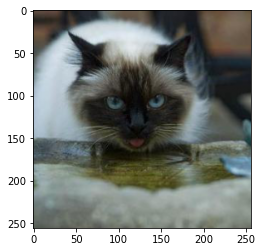

In [7]:
train_b1_img, train_b1_label = next(iter(train_r3_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model (6 conv layers)

In [8]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)     
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model3 = PetCNN6()
loss_function = nn.NLLLoss()


print(model3)
        

PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 128,

In [9]:
learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model3.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_r3_loader:
        model3.train()
        out = model3(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model3.eval()
                with torch.no_grad():
                    train_r3_part = DataLoader(train_r3,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_r3_part))
                    train_out = model3(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model3(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


Epoch:0
Iteration:50
Time taken for the last 50 iterations: 34.46098351478577
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 43.5857150554657
Epoch:1
Iteration:150
Time taken for the last 50 iterations: 44.17099905014038
Current training loss:3.4805381298065186
Current training accuracy:0.076171875
Current validation loss:3.508193016052246
Current validation accuracy:0.0637156292796135
Epoch:1
Iteration:200
Time taken for the last 50 iterations: 35.73897409439087
Current training loss:3.404273271560669
Current training accuracy:0.06640625
Current validation loss:3.4521336555480957
Current validation accuracy:0.06773976981639862
Epoch:2
Iteration:250
Time taken for the last 50 iterations: 36.22373962402344
Current training loss:3.3682026863098145
Current training accuracy:0.07666015625
Current validation loss:3.394521713256836
Current validation accuracy:0.09188464283943176
Epoch:2
Iteration:300
Time taken for the last 50 iterations: 36.67923903465271
Current training loss

Current training loss:2.154723644256592
Current training accuracy:0.40478515625
Current validation loss:2.631446599960327
Current validation accuracy:0.27230048179626465
Epoch:16
Iteration:1800
Time taken for the last 50 iterations: 35.26499962806702
Current training loss:2.1075849533081055
Current training accuracy:0.419921875
Current validation loss:2.6308348178863525
Current validation accuracy:0.2588866651058197
Epoch:16
Iteration:1850
Time taken for the last 50 iterations: 35.15672993659973
Current training loss:2.037168025970459
Current training accuracy:0.4345703125
Current validation loss:2.5611863136291504
Current validation accuracy:0.2736418545246124
Epoch:17
Iteration:1900
Time taken for the last 50 iterations: 35.11808133125305
Current training loss:2.096348524093628
Current training accuracy:0.4150390625
Current validation loss:2.6204776763916016
Current validation accuracy:0.2810194492340088
Epoch:17
Iteration:1950
Time taken for the last 50 iterations: 35.47738075256348

Epoch:30
Iteration:3400
Time taken for the last 50 iterations: 35.37538552284241
Current training loss:1.1662601232528687
Current training accuracy:0.7255859375
Current validation loss:2.4054529666900635
Current validation accuracy:0.33668678998947144
Epoch:31
Iteration:3450
Time taken for the last 50 iterations: 35.52676963806152
Current training loss:1.0408833026885986
Current training accuracy:0.7763671875
Current validation loss:2.313063859939575
Current validation accuracy:0.3588195741176605
Epoch:31
Iteration:3500
Time taken for the last 50 iterations: 35.466145277023315
Current training loss:1.1413458585739136
Current training accuracy:0.73974609375
Current validation loss:2.384629964828491
Current validation accuracy:0.32528504729270935
Epoch:31
Iteration:3550
Time taken for the last 50 iterations: 35.424846172332764
Current training loss:1.0452784299850464
Current training accuracy:0.7666015625
Current validation loss:2.355715274810791
Current validation accuracy:0.34272301197

Epoch:45
Iteration:5050
Time taken for the last 50 iterations: 35.48722696304321
Current training loss:0.481253981590271
Current training accuracy:0.9345703125
Current validation loss:2.325068473815918
Current validation accuracy:0.3661971688270569
Epoch:45
Iteration:5100
Time taken for the last 50 iterations: 35.4392204284668
Current training loss:0.5827915072441101
Current training accuracy:0.90478515625
Current validation loss:2.3882319927215576
Current validation accuracy:0.35211268067359924
Epoch:46
Iteration:5150
Time taken for the last 50 iterations: 35.45690631866455
Current training loss:0.5400263071060181
Current training accuracy:0.9140625
Current validation loss:2.3627023696899414
Current validation accuracy:0.35077130794525146
Epoch:46
Iteration:5200
Time taken for the last 50 iterations: 35.46906280517578
Current training loss:0.4791247546672821
Current training accuracy:0.9287109375
Current validation loss:2.3501131534576416
Current validation accuracy:0.3568075001239776

Current validation loss:2.4346394538879395
Current validation accuracy:0.3501006066799164
Epoch:60
Iteration:6700
Time taken for the last 50 iterations: 35.41936755180359
Current training loss:0.28126782178878784
Current training accuracy:0.9716796875
Current validation loss:2.3903861045837402
Current validation accuracy:0.3554661273956299
Epoch:60
Iteration:6750
Time taken for the last 50 iterations: 35.479758977890015
Current training loss:0.2488624006509781
Current training accuracy:0.974609375
Current validation loss:2.4414079189300537
Current validation accuracy:0.3494299054145813
Epoch:61
Iteration:6800
Time taken for the last 50 iterations: 35.371020793914795
Current training loss:0.23874780535697937
Current training accuracy:0.9755859375
Current validation loss:2.4284989833831787
Current validation accuracy:0.3594902753829956
Epoch:61
Iteration:6850
Time taken for the last 50 iterations: 35.3182327747345
Current training loss:0.2536256015300751
Current training accuracy:0.97509

Current training loss:0.14180567860603333
Current training accuracy:0.990234375
Current validation loss:2.530184030532837
Current validation accuracy:0.34741783142089844
Epoch:75
Iteration:8350
Time taken for the last 50 iterations: 35.324320793151855
Current training loss:0.14811590313911438
Current training accuracy:0.99365234375
Current validation loss:2.5433785915374756
Current validation accuracy:0.3541247546672821
Epoch:75
Iteration:8400
Time taken for the last 50 iterations: 35.346973180770874
Current training loss:0.14203867316246033
Current training accuracy:0.99365234375
Current validation loss:2.5147745609283447
Current validation accuracy:0.3501006066799164
Epoch:76
Iteration:8450
Time taken for the last 50 iterations: 35.59041118621826
Current training loss:0.1490892767906189
Current training accuracy:0.990234375
Current validation loss:2.4300808906555176
Current validation accuracy:0.3702213168144226
Epoch:76
Iteration:8500
Time taken for the last 50 iterations: 35.541454

Epoch:89
Iteration:9950
Time taken for the last 50 iterations: 35.44376301765442
Current training loss:0.10016576200723648
Current training accuracy:0.9970703125
Current validation loss:2.5807347297668457
Current validation accuracy:0.3648557960987091
Epoch:90
Iteration:10000
Time taken for the last 50 iterations: 35.406198501586914
Current training loss:0.11286444962024689
Current training accuracy:0.99609375
Current validation loss:2.570979118347168
Current validation accuracy:0.36351442337036133
Epoch:90
Iteration:10050
Time taken for the last 50 iterations: 35.392584562301636
Current training loss:0.11699334532022476
Current training accuracy:0.99267578125
Current validation loss:2.5882279872894287
Current validation accuracy:0.3547954261302948
Epoch:90
Iteration:10100
Time taken for the last 50 iterations: 35.29611897468567
Current training loss:0.10081732273101807
Current training accuracy:0.9951171875
Current validation loss:2.5603177547454834
Current validation accuracy:0.35144

Current validation loss:2.652252435684204
Current validation accuracy:0.35077130794525146
Epoch:104
Iteration:11600
Time taken for the last 50 iterations: 35.48954391479492
Current training loss:0.07479279488325119
Current training accuracy:0.9970703125
Current validation loss:2.6415624618530273
Current validation accuracy:0.35680750012397766
Epoch:104
Iteration:11650
Time taken for the last 50 iterations: 35.22162485122681
Current training loss:0.07464949786663055
Current training accuracy:0.9970703125
Current validation loss:2.6259517669677734
Current validation accuracy:0.35680750012397766
Epoch:105
Iteration:11700
Time taken for the last 50 iterations: 35.36949372291565
Current training loss:0.06697194278240204
Current training accuracy:0.99853515625
Current validation loss:2.6025707721710205
Current validation accuracy:0.3641851246356964
Epoch:105
Iteration:11750
Time taken for the last 50 iterations: 35.30194973945618
Current training loss:0.0644284263253212
Current training accu

Epoch:118
Iteration:13200
Time taken for the last 50 iterations: 35.52478003501892
Current training loss:0.052154283970594406
Current training accuracy:0.99853515625
Current validation loss:2.6909306049346924
Current validation accuracy:0.3554661273956299
Epoch:119
Iteration:13250
Time taken for the last 50 iterations: 35.52342224121094
Current training loss:0.05596400052309036
Current training accuracy:0.99853515625
Current validation loss:2.6546876430511475
Current validation accuracy:0.35613682866096497
Epoch:119
Iteration:13300
Time taken for the last 50 iterations: 35.388986349105835
Current training loss:0.05896802619099617
Current training accuracy:0.99609375
Current validation loss:2.66755747795105
Current validation accuracy:0.3541247546672821
Epoch:120
Iteration:13350
Time taken for the last 50 iterations: 35.40626096725464
Current training loss:0.052658189088106155
Current training accuracy:0.9990234375
Current validation loss:2.6713733673095703
Current validation accuracy:0

Current training loss:0.047487255185842514
Current training accuracy:0.99853515625
Current validation loss:2.6648213863372803
Current validation accuracy:0.34138160943984985
Epoch:133
Iteration:14850
Time taken for the last 50 iterations: 35.28410506248474
Current training loss:0.0421549454331398
Current training accuracy:1.0
Current validation loss:2.656075954437256
Current validation accuracy:0.3487592339515686
Epoch:134
Iteration:14900
Time taken for the last 50 iterations: 35.33347272872925
Current training loss:0.03122749924659729
Current training accuracy:1.0
Current validation loss:2.7148663997650146
Current validation accuracy:0.35144197940826416
Epoch:134
Iteration:14950
Time taken for the last 50 iterations: 35.362666606903076
Current training loss:0.05533195286989212
Current training accuracy:0.99853515625
Current validation loss:2.6587281227111816
Current validation accuracy:0.34205231070518494
Epoch:135
Iteration:15000
Time taken for the last 50 iterations: 35.519431829452

Current validation loss:2.754912853240967
Current validation accuracy:0.34138160943984985
Epoch:148
Iteration:16450
Time taken for the last 50 iterations: 35.53265118598938
Current training loss:0.03703546151518822
Current training accuracy:0.99853515625
Current validation loss:2.7293691635131836
Current validation accuracy:0.3440643846988678
Epoch:148
Iteration:16500
Time taken for the last 50 iterations: 35.69149160385132
Current training loss:0.033994030207395554
Current training accuracy:0.99853515625
Current validation loss:2.7311408519744873
Current validation accuracy:0.35278335213661194
Epoch:149
Iteration:16550
Time taken for the last 50 iterations: 35.386924028396606
Current training loss:0.03856023773550987
Current training accuracy:0.9990234375
Current validation loss:2.7696468830108643
Current validation accuracy:0.3373574912548065
Epoch:149
Iteration:16600
Time taken for the last 50 iterations: 35.274975299835205
Current training loss:0.04269062355160713
Current training 

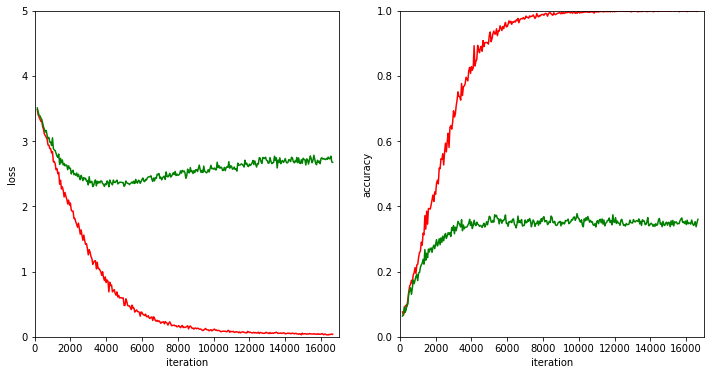

In [10]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,17000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,17000)
acc_graph.set_ylim(0,1)

plt.show()